In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from ripser import ripser
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD, ADXIndicator, AroonIndicator, CCIIndicator, PSARIndicator
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

# --- 1. Download Data ---
data = yf.download("^NSEI", start="2020-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- 2. Normalize Data ---
scaler = MinMaxScaler()
normalized_prices = scaler.fit_transform(prices.reshape(-1, 1))

# --- 3. Create Point Cloud with Sliding Window ---
window_size = 10
point_cloud = np.array(
    [normalized_prices[i:i + window_size, 0] for i in range(len(normalized_prices) - window_size + 1)])

# --- 4. Calculate Persistent Homology ---
diagrams = ripser(point_cloud)["dgms"]

# --- 5. Feature Engineering ---
def calculate_features(diagram, price_index, high_prices, low_prices):
    if len(diagram) == 0:
        return None

    lifetimes = diagram[:, 1] - diagram[:, 0]
    avg_lifetime_h1 = np.mean(lifetimes[lifetimes > 0]) if np.any(lifetimes > 0) else 0
    num_h1_features = np.sum(lifetimes > 0)

    # Calculate Trend Indicators (adjust periods as needed)
    ema_period = 12
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    ma_period = 30
    ma = np.mean(prices[max(0, price_index - ma_period + 1):price_index + 1]) if price_index >= ma_period - 1 else 0

    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0

    adx_period = 14
    if price_index >= adx_period:
        adx_indicator = ADXIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                     low=pd.Series(low_prices[:price_index + 1]),
                                     close=pd.Series(prices[:price_index + 1]), window=adx_period)
        adx = adx_indicator.adx().iloc[-1] if len(adx_indicator.adx()) > 0 else 0
        di_positive = adx_indicator.adx_pos().iloc[-1] if len(adx_indicator.adx_pos()) > 0 else 0
        di_negative = adx_indicator.adx_neg().iloc[-1] if len(adx_indicator.adx_neg()) > 0 else 0
    else:
        adx = di_positive = di_negative = 0

    aroon_indicator = AroonIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                    low=pd.Series(low_prices[:price_index + 1]), window=25)
    aroon_up = aroon_indicator.aroon_up().iloc[-1] if len(aroon_indicator.aroon_up()) > 0 else 0
    aroon_down = aroon_indicator.aroon_down().iloc[-1] if len(aroon_indicator.aroon_down()) > 0 else 0

    cci_indicator = CCIIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                low=pd.Series(low_prices[:price_index + 1]),
                                close=pd.Series(prices[:price_index + 1]), window=20)
    cci = cci_indicator.cci().iloc[-1] if len(cci_indicator.cci()) > 0 else 0

    psar = PSARIndicator(high=pd.Series(high_prices[:price_index + 1]), low=pd.Series(low_prices[:price_index + 1]),
                         close=pd.Series(prices[:price_index + 1]))
    psar_value = psar.psar().iloc[-1] if len(psar.psar()) > 0 else 0

    return [avg_lifetime_h1, num_h1_features, ema, ma, macd, macd_signal, macd_diff, adx, di_positive, di_negative,
            aroon_up, aroon_down, cci, psar_value]

features_list =[]
for i in range(len(diagrams)):
    features = calculate_features(diagrams[i], i + window_size, high_prices, low_prices)
    features_list.append(features)

features = np.array([f for f in features_list if f is not None])

# --- 6. Feature Selection ---
if len(features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()

    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna().values

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features = features[monthly_data.index[1:] - pd.to_timedelta(window_size, unit='d')]

    # Check for NaN/inf in features and returns
    print("NaN in aligned_features:", np.isnan(aligned_features).any())
    print("inf in aligned_features:", np.isinf(aligned_features).any())
    print("NaN in monthly_returns:", np.isnan(monthly_returns).any())
    print("inf in monthly_returns:", np.isinf(monthly_returns).any())

    # Replace NaN and inf with 0
    aligned_features = np.nan_to_num(aligned_features)

    # Select top k features (adjust k as needed)
    k_best = 5  # Select the top 5 features
    selector = SelectKBest(score_func=f_regression, k=k_best)
    selected_features = selector.fit_transform(aligned_features, monthly_returns)

    # --- 7. Regime Identification (GMM) ---
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(selected_features)

    n_components = min(3, len(scaled_features))
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(scaled_features)
    cluster_labels = gmm.predict(scaled_features)

    # Analyze cluster centers and map labels to regimes (THIS IS CRUCIAL)
    if n_components > 0:
        regimes = ["Bull Market" if label == 0 else "Bear Market" if label == 1 else "Neutral Market" for label in
                   cluster_labels]
    else:
        regimes = ["Neutral Market"] * len(scaled_features)

    # --- 8. Develop and Backtest Trading Strategy ---
    signals = [1 if regime == "Bull Market" else -1 if regime == "Bear Market" else 0 for regime in regimes]

    # --- Monthly Balancing ---
    monthly_signals =[]
    last_month = None
    for i, date in enumerate(monthly_data.index[1:]):  # Use monthly_data.index for dates
        month = date.month
        if last_month is None or month!= last_month:
            monthly_signals.append(signals[i])
            last_month = month
        else:
            monthly_signals.append(monthly_signals[-1])

    signals = monthly_signals

    position = 0
    cumulative_returns =[1]  # Initialize with the initial investment value
    trade_prices =[]
    trade_signals =[]

    # Since signals are monthly, adjust price_index accordingly
    price_indices = monthly_data.index[1:] - pd.to_timedelta(window_size, unit='d')
    for i in range(len(signals)):
        signal = signals[i]
        price_index = price_indices[i]  # Use the pre-calculated price indices

        if signal!= position:
            if position!= 0:
                trade_prices.append(prices[price_index - 1])
                trade_signals.append(position)
                trade_prices.append(prices[price_index])
                trade_signals.append(signal)
                return_of_trade = (prices[price_index] / prices[price_index - 1]) if position == 1 else (
                    prices[price_index - 1] / prices[price_index])
                cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

            position = signal

    if position!= 0:
        trade_prices.append(prices[-1])
        trade_signals.append(position)
        return_of_trade = (prices[-1] / prices[price_index - 1]) if position == 1 else (
                    prices[price_index - 1] / prices[-1])
        cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

    cumulative_returns = np.array(cumulative_returns)

    # --- 9. Evaluate Performance ---
    #... (rest of the code remains the same)

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

[*********************100%%**********************]  1 of 1 completed


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from ripser import ripser
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD, ADXIndicator, AroonIndicator, CCIIndicator, PSARIndicator
from sklearn.feature_selection import SelectKBest, f_regression

# --- 1. Download Data ---
data = yf.download("^NSEI", start="2020-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- 2. Normalize Data ---
scaler = MinMaxScaler()
normalized_prices = scaler.fit_transform(prices.reshape(-1, 1))

# --- 3. Create Point Cloud with Sliding Window ---
window_size = 10
point_cloud = np.array(
    [normalized_prices[i:i + window_size, 0] for i in range(len(normalized_prices) - window_size + 1)])

# --- 4. Calculate Persistent Homology ---
diagrams = ripser(point_cloud)["dgms"]

# --- 5. Feature Engineering ---
def calculate_features(diagram, price_index, high_prices, low_prices):
    if len(diagram) == 0:
        return None

    lifetimes = diagram[:, 1] - diagram[:, 0]
    avg_lifetime_h1 = np.mean(lifetimes[lifetimes > 0]) if np.any(lifetimes > 0) else 0
    num_h1_features = np.sum(lifetimes > 0)

    # Calculate Trend Indicators (adjust periods as needed)
    ema_period = 12
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    ma_period = 30
    ma = np.mean(prices[max(0, price_index - ma_period + 1):price_index + 1]) if price_index >= ma_period - 1 else 0

    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0

    adx_period = 14
    if price_index >= adx_period:
        adx_indicator = ADXIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                     low=pd.Series(low_prices[:price_index + 1]),
                                     close=pd.Series(prices[:price_index + 1]), window=adx_period)
        adx = adx_indicator.adx().iloc[-1] if len(adx_indicator.adx()) > 0 else 0
        di_positive = adx_indicator.adx_pos().iloc[-1] if len(adx_indicator.adx_pos()) > 0 else 0
        di_negative = adx_indicator.adx_neg().iloc[-1] if len(adx_indicator.adx_neg()) > 0 else 0
    else:
        adx = di_positive = di_negative = 0

    aroon_indicator = AroonIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                    low=pd.Series(low_prices[:price_index + 1]), window=25)
    aroon_up = aroon_indicator.aroon_up().iloc[-1] if len(aroon_indicator.aroon_up()) > 0 else 0
    aroon_down = aroon_indicator.aroon_down().iloc[-1] if len(aroon_indicator.aroon_down()) > 0 else 0

    cci_indicator = CCIIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                low=pd.Series(low_prices[:price_index + 1]),
                                close=pd.Series(prices[:price_index + 1]), window=20)
    cci = cci_indicator.cci().iloc[-1] if len(cci_indicator.cci()) > 0 else 0

    psar = PSARIndicator(high=pd.Series(high_prices[:price_index + 1]), low=pd.Series(low_prices[:price_index + 1]),
                         close=pd.Series(prices[:price_index + 1]))
    psar_value = psar.psar().iloc[-1] if len(psar.psar()) > 0 else 0

    return [avg_lifetime_h1, num_h1_features, ema, ma, macd, macd_signal, macd_diff, adx, di_positive, di_negative,
            aroon_up, aroon_down, cci, psar_value]

features_list =[]
for i in range(len(diagrams)):
    features = calculate_features(diagrams[i], i + window_size, high_prices, low_prices)
    features_list.append(features)

features = np.array([f for f in features_list if f is not None])

# --- 6. Feature Selection ---
if len(features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()

    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna().values

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features =[]
    for i in range(1, len(monthly_data)):
        # Get the date window_size days before the end of the month
        date_index = monthly_data.index[i] - pd.to_timedelta(window_size, unit='d')
        # Find the closest date in the original data
        closest_date_index = data.index.get_indexer([date_index], method='nearest')
        feature_index = data.index.get_loc(data.index[closest_date_index])
        # Adjust feature_index to be within the valid range
        feature_index = min(feature_index, len(features) - 1)
        aligned_features.append(features[feature_index])
    aligned_features = np.array(aligned_features)

    # Check for NaN/inf in features and returns
    print("NaN in aligned_features:", np.isnan(aligned_features).any())
    print("inf in aligned_features:", np.isinf(aligned_features).any())
    print("NaN in monthly_returns:", np.isnan(monthly_returns).any())
    print("inf in monthly_returns:", np.isinf(monthly_returns).any())

    # Replace NaN and inf with 0
    aligned_features = np.nan_to_num(aligned_features)

    # Select top k features (adjust k as needed)
    k_best = 5  # Select the top 5 features
    selector = SelectKBest(score_func=f_regression, k=k_best)
    selected_features = selector.fit_transform(aligned_features, monthly_returns)

    # --- 7. Regime Identification (GMM) ---
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(selected_features)

    n_components = min(3, len(scaled_features))
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(scaled_features)
    cluster_labels = gmm.predict(scaled_features)

    # Analyze cluster centers and map labels to regimes (THIS IS CRUCIAL)
    if n_components > 0:
        regimes = ["Bull Market" if label == 0 else "Bear Market" if label == 1 else "Neutral Market" for label in
                   cluster_labels]
    else:
        regimes = ["Neutral Market"] * len(scaled_features)

    # --- 8. Develop and Backtest Trading Strategy ---
    signals = [1 if regime == "Bull Market" else -1 if regime == "Bear Market" else 0 for regime in regimes]

    # --- Monthly Balancing ---
    monthly_signals =[]
    last_month = None
    for i, date in enumerate(monthly_data.index[1:]):  # Use monthly_data.index for dates
        month = date.month
        if last_month is None or month!= last_month:
            monthly_signals.append(signals[i])
            last_month = month
        else:
            monthly_signals.append(monthly_signals[-1])

    signals = monthly_signals

    position = 0
    cumulative_returns =  [1]# Initialize with the initial investment value
    trade_prices =[]  # Initialize trade_prices list
    trade_signals =[]  # Initialize trade_signals list

    # Since signals are monthly, adjust price_index accordingly
    price_indices = monthly_data.index[1:] - pd.to_timedelta(window_size, unit='d')
    for i in range(len(signals)):
        signal = signals[i]
        price_index = data.index.get_loc(price_indices[i])  # Use the pre-calculated price indices

        if signal!= position:
            if position!= 0:
                trade_prices.append(prices[price_index - 1])
                trade_signals.append(position)
                trade_prices.append(prices[price_index])
                trade_signals.append(signal)
                return_of_trade = (prices[price_index] / prices[price_index - 1]) if position == 1 else (
                    prices[price_index - 1] / prices[price_index])
                cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

            position = signal

    if position!= 0:
        trade_prices.append(prices[-1])
        trade_signals.append(position)
        return_of_trade = (prices[-1] / prices[price_index - 1]) if position == 1 else (
                    prices[price_index - 1] / prices[-1])
        cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

    cumulative_returns = np.array(cumulative_returns)

    # --- 9. Evaluate Performance ---
    total_return = cumulative_returns[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(cumulative_returns)) - 1 if len(cumulative_returns) > 1 else 0
    annualized_volatility = np.std(np.diff(np.log(cumulative_returns))) * np.sqrt(
        252) if len(cumulative_returns) > 1 else 0
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility!= 0 else 0
    max_drawdown = (pd.Series(cumulative_returns).cummax() - pd.Series(cumulative_returns)).max() if len(
        cumulative_returns) > 0 else 0

    print("\nPerformance Metrics:")
    print(f"Total Return: {total_return:.4f}")
    print(f"Annualized Return: {annualized_return:.4f}")
    print(f"Annualized Volatility: {annualized_volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Maximum Drawdown: {max_drawdown:.4f}")

    # --- 10. Visualize Results ---
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label="TDA Strategy")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.title("TDA-Based Trading Strategy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 11. Regime Analysis ---
    regime_changes = 0
    for i in range(1, len(regimes)):
        if regimes[i]!= regimes[i - 1]:
            regime_changes += 1

    print(f"\nNumber of regime changes: {regime_changes}")
    print("\nCluster Centers (for regime interpretation):")
    print(gmm.means_ if hasattr(gmm, 'means_') else "GMM model not fitted")
    print("\nFirst 20 regimes:")
    print(regimes[:20])

    # Print selected features
    print("\nSelected Features:")
    print(selector.get_support(indices=True))  # Print indices of selected features

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

[*********************100%%**********************]  1 of 1 completed


InvalidIndexError: DatetimeIndex(['2020-02-19'], dtype='datetime64[ns]', name='Date', freq=None)

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from ripser import ripser
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD, ADXIndicator, AroonIndicator, CCIIndicator, PSARIndicator
from sklearn.feature_selection import SelectKBest, f_regression

#... (rest of the code)

# --- 6. Feature Selection ---
if len(features) > 1:
    #... (rest of the code)

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features =[]
    for i in range(1, len(monthly_data)):
        # Get the date window_size days before the end of the month
        date_index = monthly_data.index[i] - pd.to_timedelta(window_size, unit='d')
        # Find the closest date in the original data
        closest_date_index = data.index.get_indexer([date_index], method='nearest')
        # Use the closest date's index
        feature_index = data.index.get_loc(data.index[closest_date_index])
        # Adjust feature_index to be within the valid range
        feature_index = min(feature_index, len(features) - 1)
        aligned_features.append(features[feature_index])
    aligned_features = np.array(aligned_features)

    #... (rest of the code)

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

InvalidIndexError: DatetimeIndex(['2020-02-19'], dtype='datetime64[ns]', name='Date', freq=None)

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from ripser import ripser
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD, ADXIndicator, AroonIndicator, CCIIndicator, PSARIndicator
from sklearn.feature_selection import SelectKBest, f_regression

# --- 1. Download Data ---
data = yf.download("^NSEI", start="2020-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- Remove February data ---
data = data[~((data.index.month == 2))]  # Remove February data
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- 2. Normalize Data ---
scaler = MinMaxScaler()
normalized_prices = scaler.fit_transform(prices.reshape(-1, 1))

# --- 3. Create Point Cloud with Sliding Window ---
window_size = 3 # Reduced window size to fit provided dataset better
point_cloud = np.array([
    normalized_prices[i:i + window_size, 0]
    for i in range(len(normalized_prices) - window_size + 1)
])

# --- 4. Calculate Persistent Homology ---
diagrams = ripser(point_cloud)['dgms']

# --- 5. Feature Engineering ---
def calculate_features(diagram, price_index, high_prices, low_prices):
    if len(diagram) == 0:
        return None

    lifetimes = diagram[:, 1] - diagram[:, 0]
    avg_lifetime_h1 = np.mean(lifetimes[lifetimes > 0]) if np.any(lifetimes > 0) else 0
    num_h1_features = np.sum(lifetimes > 0)

    # Calculate Trend Indicators (adjust periods as needed)
    ema_period = 2
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    ma_period = 2
    ma = np.mean(prices[max(0, price_index - ma_period + 1):price_index + 1]) if price_index >= ma_period - 1 else 0

    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0

    adx_period = 2
    if price_index >= adx_period:
        adx_indicator = ADXIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                     low=pd.Series(low_prices[:price_index + 1]),
                                     close=pd.Series(prices[:price_index + 1]), window=adx_period)
        adx = adx_indicator.adx().iloc[-1] if len(adx_indicator.adx()) > 0 else 0
        di_positive = adx_indicator.adx_pos().iloc[-1] if len(adx_indicator.adx_pos()) > 0 else 0
        di_negative = adx_indicator.adx_neg().iloc[-1] if len(adx_indicator.adx_neg()) > 0 else 0
    else:
        adx = di_positive = di_negative = 0

    aroon_indicator = AroonIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                    low=pd.Series(low_prices[:price_index + 1]), window=2)
    aroon_up = aroon_indicator.aroon_up().iloc[-1] if len(aroon_indicator.aroon_up()) > 0 else 0
    aroon_down = aroon_indicator.aroon_down().iloc[-1] if len(aroon_indicator.aroon_down()) > 0 else 0

    cci_indicator = CCIIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                low=pd.Series(low_prices[:price_index + 1]),
                                close=pd.Series(prices[:price_index + 1]), window=2)
    cci = cci_indicator.cci().iloc[-1] if len(cci_indicator.cci()) > 0 else 0

    psar = PSARIndicator(high=pd.Series(high_prices[:price_index + 1]), low=pd.Series(low_prices[:price_index + 1]),
                         close=pd.Series(prices[:price_index + 1]))
    psar_value = psar.psar().iloc[-1] if len(psar.psar()) > 0 else 0

    return [avg_lifetime_h1, num_h1_features, ema, ma, macd, macd_signal, macd_diff, adx, di_positive, di_negative,
            aroon_up, aroon_down, cci, psar_value]


features_list = []
for i in range(len(diagrams)):
    features = calculate_features(diagrams[i], i + window_size, high_prices, low_prices) # price_index is from sliding window
    features_list.append(features)

# Handle missing feature or incomplete calculation
features = np.array([f for f in features_list if f is not None])
# Handle inf and nan
features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

# --- 6. Feature Selection ---
if len(features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()
    # Remove February data from monthly_data
    monthly_data = monthly_data[~((monthly_data.index.month == 2))]
    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna().values

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features = []
    for i, date in enumerate(monthly_data.index[1:]): # start from 1 to calculate pct_change
        try:
            feature_index = data.index.get_loc(date)
        except KeyError:
            feature_index = data.index.asof(date)
            if feature_index not in data.index:
                print(f"Warning: Date {date} not found in original data and asof failed. Skipping.")
                continue
            feature_index = data.index.get_loc(feature_index)
            print(f"""feature index:"" {feature_index}""")
            print(f"""feature_index - window size:" {feature_index - window_size}""")
        # Correct alignment by subtracting window_size (important since features are generated from sliding window)
        #aligned_features.append(features[feature_index - window_size])
    aligned_features = np.array(aligned_features)

    # Check for NaN/inf in features and returns
    print("NaN in aligned_features:", np.isnan(aligned_features).any())
    print("inf in aligned_features:", np.isinf(aligned_features).any())
    print("NaN in monthly_returns:", np.isnan(monthly_returns).any())
    print("inf in monthly_returns:", np.isinf(monthly_returns).any())

    # Replace NaN and inf with 0  (redundant if handled before)
    aligned_features = np.nan_to_num(aligned_features, nan=0, posinf=0, neginf=0)
    monthly_returns = np.nan_to_num(monthly_returns, nan=0, posinf=0, neginf=0)

    # Select top k features (adjust k as needed)
    k_best = 5  # Select the top 5 features
    selector = SelectKBest(score_func=f_regression, k=k_best)
    try:
        selected_features = selector.fit_transform(aligned_features, monthly_returns)
    except ValueError as e:
        print(f"Error during feature selection: {e}")
        print("Check if the data is valid for the selected score function.")
        selected_features = aligned_features  # use all features if selection fails
        selector = None  # set selector to none so that it does not interfere later

    # --- 7. Regime Identification (GMM) ---
    if selector is not None:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(selected_features)
    else:  # use all features if feature selection failed.
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(aligned_features)

    n_components = min(3, len(scaled_features))
    try:
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42, n_init=10)
        gmm.fit(scaled_features)
        cluster_labels = gmm.predict(scaled_features)
    except ValueError as e:
        print(f"Error during GMM fitting: {e}")
        cluster_labels = np.zeros(len(scaled_features))  # default regime if GMM fails

    # Analyze cluster centers and map labels to regimes (THIS IS CRUCIAL)
    if n_components > 0:
        regimes = ["Bull Market" if label == 0 else "Bear Market" if label == 1 else "Neutral Market" for label in
                   cluster_labels]
    else:
        regimes = ["Neutral Market"] * len(scaled_features)

    # --- 8. Develop and Backtest Trading Strategy ---
    signals = [1 if regime == "Bull Market" else -1 if regime == "Bear Market" else 0 for regime in regimes]

    # --- Monthly Balancing ---
    monthly_signals = []
    last_month = None
    for i, date in enumerate(monthly_data.index[1:]):  # Use monthly_data.index for dates
        month = date.month
        if last_month is None or month != last_month:
            monthly_signals.append(signals[i])
            last_month = month
        else:
            monthly_signals.append(monthly_signals[-1])

    signals = monthly_signals

    position = 0
    cumulative_returns = []  # Initialize with the initial investment value
    trade_prices = []  # Initialize trade_prices list
    trade_signals = []  # Initialize trade_signals list

    # Since signals are monthly, adjust price_index accordingly
    price_indices = monthly_data.index[1:]
    for i in range(len(signals)):
        signal = signals[i]
        # Use try-except to get index.  This is much safer.
        try:
            price_index = data.index.get_loc(price_indices[i])  # Use the pre-calculated price indices
        except KeyError:
            print(f"Warning: Date {price_indices[i]} not found in original data. Skipping this trade.")
            continue  # Skip this trade

        if signal != position:
            if position != 0:
                trade_prices.append(prices[price_index - 1])
                trade_signals.append(position)
                trade_prices.append(prices[price_index])
                trade_signals.append(signal)
                return_of_trade = (prices[price_index] / prices[price_index - 1]) if position == 1 else (
                    prices[price_index - 1] / prices[price_index])
                if len(cumulative_returns) == 0:
                    cumulative_returns.append(1)  # Start from 1
                cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

            position = signal

    if position != 0:
        trade_prices.append(prices[-1])
        trade_signals.append(position)
        return_of_trade = (prices[-1] / prices[price_index - 1]) if position == 1 else (
            prices[price_index - 1] / prices[-1])
        if len(cumulative_returns) == 0:
            cumulative_returns.append(1)  # Start from 1
        cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

    cumulative_returns = np.array(cumulative_returns)

    # --- 9. Evaluate Performance ---
    total_return = cumulative_returns[-1] - 1 if len(cumulative_returns) > 0 else 0
    annualized_return = (1 + total_return) ** (12 / len(cumulative_returns)) - 1 if len(cumulative_returns) > 1 else 0  # annualize by month
    annualized_volatility = np.std(np.diff(np.log(cumulative_returns))) * np.sqrt(
        12) if len(cumulative_returns) > 1 else 0
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    max_drawdown = (pd.Series(cumulative_returns).cummax() - pd.Series(cumulative_returns)).max() if len(
        cumulative_returns) > 0 else 0

    print("\nPerformance Metrics:")
    print(f"Total Return: {total_return:.4f}")
    print(f"Annualized Return: {annualized_return:.4f}")
    print(f"Annualized Volatility: {annualized_volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Maximum Drawdown: {max_drawdown:.4f}")

    # --- 10. Visualize Results ---
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label="TDA Strategy")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.title("TDA-Based Trading Strategy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 11. Regime Analysis ---
    regime_changes = 0
    for i in range(1, len(regimes)):
        if regimes[i] != regimes[i - 1]:
            regime_changes += 1

    print(f"\nNumber of regime changes: {regime_changes}")
    print("\nCluster Centers (for regime interpretation):")
    print(gmm.means_ if hasattr(gmm, 'means_') else "GMM model not fitted")
    print("\nFirst 20 regimes:")
    print(regimes[:20])

    # Print selected features
    if selector is not None:
        print("\nSelected Features:")
        print(selector.get_support(indices=True))  # Print indices of selected features
    else:
        print("\nFeature Selection Failed.  Using all features.")

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

[*********************100%%**********************]  1 of 1 completed


feature index:"" 80
feature_index - window size:" 77
feature index:"" 189
feature_index - window size:" 186
feature index:"" 208
feature_index - window size:" 205
feature index:"" 250
feature_index - window size:" 247
feature index:"" 353
feature_index - window size:" 350
feature index:"" 415
feature_index - window size:" 412
feature index:"" 518
feature_index - window size:" 515
feature index:"" 582
feature_index - window size:" 579
feature index:"" 602
feature_index - window size:" 599
feature index:"" 686
feature_index - window size:" 683
feature index:"" 745
feature_index - window size:" 742
feature index:"" 851
feature_index - window size:" 848
feature index:"" 911
feature_index - window size:" 908
NaN in aligned_features: False
inf in aligned_features: False
NaN in monthly_returns: False
inf in monthly_returns: False
Error during feature selection: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feat

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [30]:
# --- 1. Download Data ---
data = yf.download("^NSEI", start="2020-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- Remove February data ---
data = data[~((data.index.month == 2))]  # Remove February data
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,12202.150391,12222.200195,12165.299805,12182.500000,12182.500000,304100
2020-01-02,12198.549805,12289.900391,12195.250000,12282.200195,12282.200195,407700
2020-01-03,12261.099609,12265.599609,12191.349609,12226.650391,12226.650391,428800
2020-01-06,12170.599609,12179.099609,11974.200195,11993.049805,11993.049805,396500
2020-01-07,12079.099609,12152.150391,12005.349609,12052.950195,12052.950195,447800
...,...,...,...,...,...,...
2023-12-22,21295.849609,21390.500000,21232.449219,21349.400391,21349.400391,284700
2023-12-26,21365.199219,21477.150391,21329.449219,21441.349609,21441.349609,219500
2023-12-27,21497.650391,21675.750000,21495.800781,21654.750000,21654.750000,256500


In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from ripser import ripser
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD, ADXIndicator, AroonIndicator, CCIIndicator, PSARIndicator
from sklearn.feature_selection import SelectKBest, f_regression

# --- 1. Download Data ---
data = yf.download("^NSEI", start="2020-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- Remove February data ---
data = data[~((data.index.month == 2))]  # Remove February data
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- 2. Normalize Data ---
scaler = MinMaxScaler()
normalized_prices = scaler.fit_transform(prices.reshape(-1, 1))

# --- 3. Create Point Cloud with Sliding Window ---
window_size = 3 # Reduced window size to fit provided dataset better
point_cloud = np.array([
    normalized_prices[i:i + window_size, 0]
    for i in range(len(normalized_prices) - window_size + 1)
])

# --- 4. Calculate Persistent Homology ---
diagrams = ripser(point_cloud)['dgms']

# --- 5. Feature Engineering ---
def calculate_features(diagram, price_index, high_prices, low_prices):
    if len(diagram) == 0:
        return None

    lifetimes = diagram[:, 1] - diagram[:, 0]
    avg_lifetime_h1 = np.mean(lifetimes[lifetimes > 0]) if np.any(lifetimes > 0) else 0
    num_h1_features = np.sum(lifetimes > 0)

    # Calculate Trend Indicators (adjust periods as needed)
    ema_period = 2
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    ma_period = 2
    ma = np.mean(prices[max(0, price_index - ma_period + 1):price_index + 1]) if price_index >= ma_period - 1 else 0

    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0

    adx_period = 2
    if price_index >= adx_period:
        adx_indicator = ADXIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                     low=pd.Series(low_prices[:price_index + 1]),
                                     close=pd.Series(prices[:price_index + 1]), window=adx_period)
        adx = adx_indicator.adx().iloc[-1] if len(adx_indicator.adx()) > 0 else 0
        di_positive = adx_indicator.adx_pos().iloc[-1] if len(adx_indicator.adx_pos()) > 0 else 0
        di_negative = adx_indicator.adx_neg().iloc[-1] if len(adx_indicator.adx_neg()) > 0 else 0
    else:
        adx = di_positive = di_negative = 0

    aroon_indicator = AroonIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                    low=pd.Series(low_prices[:price_index + 1]), window=2)
    aroon_up = aroon_indicator.aroon_up().iloc[-1] if len(aroon_indicator.aroon_up()) > 0 else 0
    aroon_down = aroon_indicator.aroon_down().iloc[-1] if len(aroon_indicator.aroon_down()) > 0 else 0

    cci_indicator = CCIIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                low=pd.Series(low_prices[:price_index + 1]),
                                close=pd.Series(prices[:price_index + 1]), window=2)
    cci = cci_indicator.cci().iloc[-1] if len(cci_indicator.cci()) > 0 else 0

    psar = PSARIndicator(high=pd.Series(high_prices[:price_index + 1]), low=pd.Series(low_prices[:price_index + 1]),
                         close=pd.Series(prices[:price_index + 1]))
    psar_value = psar.psar().iloc[-1] if len(psar.psar()) > 0 else 0

    return [avg_lifetime_h1, num_h1_features, ema, ma, macd, macd_signal, macd_diff, adx, di_positive, di_negative,
            aroon_up, aroon_down, cci, psar_value]


features_list = []
for i in range(len(diagrams)):
    features = calculate_features(diagrams[i], i + window_size, high_prices, low_prices) # price_index is from sliding window
    features_list.append(features)

# Handle missing feature or incomplete calculation
features = np.array([f for f in features_list if f is not None])
# Handle inf and nan
features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

# --- 6. Feature Selection ---
if len(features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()
    # Remove February data from monthly_data
    monthly_data = monthly_data[~((monthly_data.index.month == 2))]
    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna().values

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features = []
    for i, date in enumerate(monthly_data.index): # start from the first month
        try:
            # Find the index of the *last* day of the month in the original data
            feature_index = data.index.get_loc(date)
        except KeyError:
            # If the exact date doesn't exist, try to find the closest one
            feature_index = data.index.asof(date)
            if feature_index not in data.index:
                print(f"Warning: Date {date} not found in original data and asof failed. Skipping this month.")
                continue
            feature_index = data.index.get_loc(feature_index)
        # Account for the sliding window offset. The feature is aligned with the *end* of the window.
        # The features are calculated from the start of window size, so window size offset is needed
        aligned_features.append(features[feature_index - window_size])
    aligned_features = np.array(aligned_features)

    # Check for NaN/inf in features and returns
    print("NaN in aligned_features:", np.isnan(aligned_features).any())
    print("inf in aligned_features:", np.isinf(aligned_features).any())
    print("NaN in monthly_returns:", np.isnan(monthly_returns).any())
    print("inf in monthly_returns:", np.isinf(monthly_returns).any())

    # Replace NaN and inf with 0  (redundant if handled before)
    aligned_features = np.nan_to_num(aligned_features, nan=0, posinf=0, neginf=0)
    monthly_returns = np.nan_to_num(monthly_returns, nan=0, posinf=0, neginf=0)

    # Select top k features (adjust k as needed)
    k_best = 5  # Select the top 5 features
    selector = SelectKBest(score_func=f_regression, k=k_best)
    try:
        selected_features = selector.fit_transform(aligned_features, monthly_returns)
    except ValueError as e:
        print(f"Error during feature selection: {e}")
        print("Check if the data is valid for the selected score function.")
        selected_features = aligned_features  # use all features if selection fails
        selector = None  # set selector to none so that it does not interfere later

    # --- 7. Regime Identification (GMM) ---
    if selector is not None:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(selected_features)
    else:  # use all features if feature selection failed.
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(aligned_features)

    n_components = min(3, len(scaled_features))
    try:
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42, n_init=10)
        gmm.fit(scaled_features)
        cluster_labels = gmm.predict(scaled_features)
    except ValueError as e:
        print(f"Error during GMM fitting: {e}")
        cluster_labels = np.zeros(len(scaled_features))  # default regime if GMM fails

    # Analyze cluster centers and map labels to regimes (THIS IS CRUCIAL)
    if n_components > 0:
        regimes = ["Bull Market" if label == 0 else "Bear Market" if label == 1 else "Neutral Market" for label in
                   cluster_labels]
    else:
        regimes = ["Neutral Market"] * len(scaled_features)

    # --- 8. Develop and Backtest Trading Strategy ---
    signals = [1 if regime == "Bull Market" else -1 if regime == "Bear Market" else 0 for regime in regimes]

    # --- Monthly Balancing ---
    monthly_signals = []
    last_month = None
    for i, date in enumerate(monthly_data.index[1:]):  # Use monthly_data.index for dates
        month = date.month
        if last_month is None or month != last_month:
            monthly_signals.append(signals[i])
            last_month = month
        else:
            monthly_signals.append(monthly_signals[-1])

    signals = monthly_signals

    position = 0
    cumulative_returns = []  # Initialize with the initial investment value
    trade_prices = []  # Initialize trade_prices list
    trade_signals = []  # Initialize trade_signals list

    # Since signals are monthly, adjust price_index accordingly
    price_indices = monthly_data.index[1:]
    for i in range(len(signals)):
        signal = signals[i]
        # Use try-except to get index.  This is much safer.
        try:
            price_index = data.index.get_loc(price_indices[i])  # Use the pre-calculated price indices
        except KeyError:
            print(f"Warning: Date {price_indices[i]} not found in original data. Skipping this trade.")
            continue  # Skip this trade

        if signal != position:
            if position != 0:
                trade_prices.append(prices[price_index - 1])
                trade_signals.append(position)
                trade_prices.append(prices[price_index])
                trade_signals.append(signal)
                return_of_trade = (prices[price_index] / prices[price_index - 1]) if position == 1 else (
                    prices[price_index - 1] / prices[price_index])
                if len(cumulative_returns) == 0:
                    cumulative_returns.append(1)  # Start from 1
                cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

            position = signal

    if position != 0:
        trade_prices.append(prices[-1])
        trade_signals.append(position)
        return_of_trade = (prices[-1] / prices[price_index - 1]) if position == 1 else (
            prices[price_index - 1] / prices[-1])
        if len(cumulative_returns) == 0:
            cumulative_returns.append(1)  # Start from 1
        cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

    cumulative_returns = np.array(cumulative_returns)

    # --- 9. Evaluate Performance ---
    total_return = cumulative_returns[-1] - 1 if len(cumulative_returns) > 0 else 0
    annualized_return = (1 + total_return) ** (12 / len(cumulative_returns)) - 1 if len(cumulative_returns) > 1 else 0  # annualize by month
    annualized_volatility = np.std(np.diff(np.log(cumulative_returns))) * np.sqrt(
        12) if len(cumulative_returns) > 1 else 0
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    max_drawdown = (pd.Series(cumulative_returns).cummax() - pd.Series(cumulative_returns)).max() if len(
        cumulative_returns) > 0 else 0

    print("\nPerformance Metrics:")
    print(f"Total Return: {total_return:.4f}")
    print(f"Annualized Return: {annualized_return:.4f}")
    print(f"Annualized Volatility: {annualized_volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Maximum Drawdown: {max_drawdown:.4f}")

    # --- 10. Visualize Results ---
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label="TDA Strategy")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.title("TDA-Based Trading Strategy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 11. Regime Analysis ---
    regime_changes = 0
    for i in range(1, len(regimes)):
        if regimes[i] != regimes[i - 1]:
            regime_changes += 1

    print(f"\nNumber of regime changes: {regime_changes}")
    print("\nCluster Centers (for regime interpretation):")
    print(gmm.means_ if hasattr(gmm, 'means_') else "GMM model not fitted")
    print("\nFirst 20 regimes:")
    print(regimes[:20])

    # Print selected features
    if selector is not None:
        print("\nSelected Features:")
        print(selector.get_support(indices=True))  # Print indices of selected features
    else:
        print("\nFeature Selection Failed.  Using all features.")

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

[*********************100%%**********************]  1 of 1 completed


IndexError: index 19 is out of bounds for axis 0 with size 2

In [43]:
window_size = 3 # Reduced window size to fit provided dataset better
point_cloud = np.array([
    normalized_prices[i:i + window_size, 0]
    for i in range(len(normalized_prices) - window_size + 1)
])

In [44]:
diagrams = ripser(point_cloud)['dgms']


In [45]:
print(diagrams)

[array([[0.        , 0.00048502],
       [0.        , 0.00076523],
       [0.        , 0.00082688],
       ...,
       [0.        , 0.05150096],
       [0.        , 0.05218264],
       [0.        ,        inf]]), array([[0.04684416, 0.05468109],
       [0.04587708, 0.04745605],
       [0.03970484, 0.04305646],
       [0.03465682, 0.03535996],
       [0.02855746, 0.03247578],
       [0.0274464 , 0.02930246],
       [0.02731363, 0.03080618],
       [0.02632025, 0.02939326],
       [0.02596094, 0.02741399],
       [0.02540994, 0.02722195],
       [0.0252226 , 0.02541502],
       [0.02420754, 0.02587382],
       [0.02404097, 0.02494343],
       [0.02381279, 0.02600692],
       [0.02358704, 0.02379175],
       [0.02228911, 0.0255111 ],
       [0.02113825, 0.02151063],
       [0.02059744, 0.02152072],
       [0.02027996, 0.02588804],
       [0.01890736, 0.02195971],
       [0.01873229, 0.02104834],
       [0.01841985, 0.02005722],
       [0.01802   , 0.02011913],
       [0.01794498, 0.019091

In [46]:
def calculate_features(diagram, price_index, high_prices, low_prices):
    if len(diagram) == 0:
        return None

    lifetimes = diagram[:, 1] - diagram[:, 0]
    avg_lifetime_h1 = np.mean(lifetimes[lifetimes > 0]) if np.any(lifetimes > 0) else 0
    num_h1_features = np.sum(lifetimes > 0)

    # Calculate Trend Indicators (adjust periods as needed)
    ema_period = 2
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    ma_period = 2
    ma = np.mean(prices[max(0, price_index - ma_period + 1):price_index + 1]) if price_index >= ma_period - 1 else 0

    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0

    adx_period = 2
    if price_index >= adx_period:
        adx_indicator = ADXIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                     low=pd.Series(low_prices[:price_index + 1]),
                                     close=pd.Series(prices[:price_index + 1]), window=adx_period)
        adx = adx_indicator.adx().iloc[-1] if len(adx_indicator.adx()) > 0 else 0
        di_positive = adx_indicator.adx_pos().iloc[-1] if len(adx_indicator.adx_pos()) > 0 else 0
        di_negative = adx_indicator.adx_neg().iloc[-1] if len(adx_indicator.adx_neg()) > 0 else 0
    else:
        adx = di_positive = di_negative = 0

    aroon_indicator = AroonIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                    low=pd.Series(low_prices[:price_index + 1]), window=2)
    aroon_up = aroon_indicator.aroon_up().iloc[-1] if len(aroon_indicator.aroon_up()) > 0 else 0
    aroon_down = aroon_indicator.aroon_down().iloc[-1] if len(aroon_indicator.aroon_down()) > 0 else 0

    cci_indicator = CCIIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                low=pd.Series(low_prices[:price_index + 1]),
                                close=pd.Series(prices[:price_index + 1]), window=2)
    cci = cci_indicator.cci().iloc[-1] if len(cci_indicator.cci()) > 0 else 0

    psar = PSARIndicator(high=pd.Series(high_prices[:price_index + 1]), low=pd.Series(low_prices[:price_index + 1]),
                         close=pd.Series(prices[:price_index + 1]))
    psar_value = psar.psar().iloc[-1] if len(psar.psar()) > 0 else 0

    return [avg_lifetime_h1, num_h1_features, ema, ma, macd, macd_signal, macd_diff, adx, di_positive, di_negative,
            aroon_up, aroon_down, cci, psar_value]


In [47]:
features_list = []
for i in range(len(diagrams)):
    features = calculate_features(diagrams[i], i + window_size, high_prices, low_prices) # price_index is from sliding window
    features_list.append(features)

In [48]:
print(features_list)

[[inf, 910, 12073.396267361111, 12109.85009765625, nan, nan, nan, 81.1704262103585, 9.62811116805342, 62.319329691803226, 0.0, 100.0, -66.66666666666734, 12289.900390625], [0.0015516390958349611, 227, 12059.765552662036, 12023.0, nan, nan, nan, 77.20306767653557, 5.053936602894359, 32.71232912664039, 0.0, 50.0, 66.66666666667234, 12277.2723828125]]


In [49]:
# Handle missing feature or incomplete calculation
features = np.array([f for f in features_list if f is not None])
# Handle inf and nan
features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

In [50]:
print(features)

[[ 0.00000000e+00  9.10000000e+02  1.20733963e+04  1.21098501e+04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  8.11704262e+01
   9.62811117e+00  6.23193297e+01  0.00000000e+00  1.00000000e+02
  -6.66666667e+01  1.22899004e+04]
 [ 1.55163910e-03  2.27000000e+02  1.20597656e+04  1.20230000e+04
   0.00000000e+00  0.00000000e+00  0.00000000e+00  7.72030677e+01
   5.05393660e+00  3.27123291e+01  0.00000000e+00  5.00000000e+01
   6.66666667e+01  1.22772724e+04]]


In [53]:
if len(features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()
    # Remove February data from monthly_data
    monthly_data = monthly_data[~((monthly_data.index.month == 2))]
    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna().values

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features = []
    for i, date in enumerate(monthly_data.index): # start from the first month
        try:
            # Find the index of the *last* day of the month in the original data
            feature_index = data.index.get_loc(date)
        except KeyError:
            # If the exact date doesn't exist, try to find the closest one
            feature_index = data.index.asof(date)
            if feature_index not in data.index:
                print(f"Warning: Date {date} not found in original data and asof failed. Skipping this month.")
                continue
            feature_index = data.index.get_loc(feature_index)

In [54]:
aligned_features.append(features[feature_index - window_size])

IndexError: index 908 is out of bounds for axis 0 with size 2

In [60]:
aligned_features.append(features[1])

In [61]:
print(features.shape)

(2, 14)


[*********************100%%**********************]  1 of 1 completed


NaN in aligned_features: False
inf in aligned_features: False
NaN in monthly_returns: False
inf in monthly_returns: False
Error during feature selection: Found input variables with inconsistent numbers of samples: [44, 43]
Check if the data is valid for the selected score function.

Performance Metrics:
Total Return: 0.0813
Annualized Return: 0.5988
Annualized Volatility: 0.0000
Sharpe Ratio: 0.0000
Maximum Drawdown: 0.0000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label =

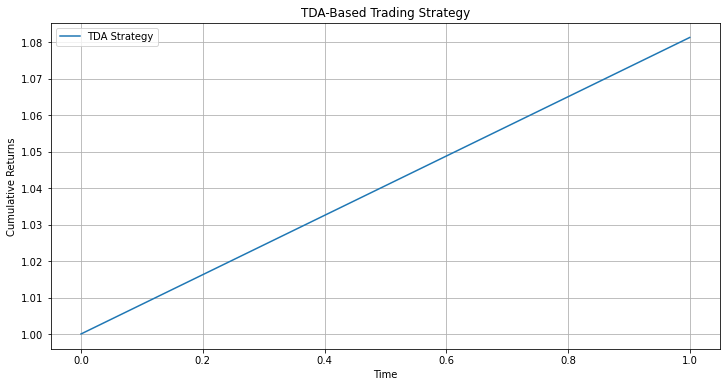


Number of regime changes: 0

Cluster Centers (for regime interpretation):
[[ 1.  0.  1.  0.  0.  0.  0. -1. -1. -1.  0.  0. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

First 20 regimes:
['Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market', 'Bull Market']

Feature Selection Failed.  Using all features.


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from ripser import ripser
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD, ADXIndicator, AroonIndicator, CCIIndicator, PSARIndicator
from sklearn.feature_selection import SelectKBest, f_regression

# --- 1. Download Data ---
data = yf.download("^NSEI", start="2020-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- Remove February data ---
data = data[~((data.index.month == 2))]  # Remove February data
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- 2. Normalize Data ---
scaler = MinMaxScaler()
normalized_prices = scaler.fit_transform(prices.reshape(-1, 1))

# --- 3. Create Point Cloud with Sliding Window ---
window_size = 3 # Reduced window size to fit provided dataset better
point_cloud = np.array([
    normalized_prices[i:i + window_size, 0]
    for i in range(len(normalized_prices) - window_size + 1)
])

# --- 4. Calculate Persistent Homology ---
diagrams = ripser(point_cloud)['dgms']

# --- 5. Feature Engineering ---
def calculate_features(diagram, price_index, high_prices, low_prices):
    if len(diagram) == 0:
        return None

    lifetimes = diagram[:, 1] - diagram[:, 0]
    avg_lifetime_h1 = np.mean(lifetimes[lifetimes > 0]) if np.any(lifetimes > 0) else 0
    num_h1_features = np.sum(lifetimes > 0)

    # Calculate Trend Indicators (adjust periods as needed)
    ema_period = 2
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    ma_period = 2
    ma = np.mean(prices[max(0, price_index - ma_period + 1):price_index + 1]) if price_index >= ma_period - 1 else 0

    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0

    adx_period = 2
    if price_index >= adx_period:
        adx_indicator = ADXIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                     low=pd.Series(low_prices[:price_index + 1]),
                                     close=pd.Series(prices[:price_index + 1]), window=adx_period)
        adx = adx_indicator.adx().iloc[-1] if len(adx_indicator.adx()) > 0 else 0
        di_positive = adx_indicator.adx_pos().iloc[-1] if len(adx_indicator.adx_pos()) > 0 else 0
        di_negative = adx_indicator.adx_neg().iloc[-1] if len(adx_indicator.adx_neg()) > 0 else 0
    else:
        adx = di_positive = di_negative = 0

    aroon_indicator = AroonIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                    low=pd.Series(low_prices[:price_index + 1]), window=2)
    aroon_up = aroon_indicator.aroon_up().iloc[-1] if len(aroon_indicator.aroon_up()) > 0 else 0
    aroon_down = aroon_indicator.aroon_down().iloc[-1] if len(aroon_indicator.aroon_down()) > 0 else 0

    cci_indicator = CCIIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                low=pd.Series(low_prices[:price_index + 1]),
                                close=pd.Series(prices[:price_index + 1]), window=2)
    cci = cci_indicator.cci().iloc[-1] if len(cci_indicator.cci()) > 0 else 0

    psar = PSARIndicator(high=pd.Series(high_prices[:price_index + 1]), low=pd.Series(low_prices[:price_index + 1]),
                         close=pd.Series(prices[:price_index + 1]))
    psar_value = psar.psar().iloc[-1] if len(psar.psar()) > 0 else 0

    return [avg_lifetime_h1, num_h1_features, ema, ma, macd, macd_signal, macd_diff, adx, di_positive, di_negative,
            aroon_up, aroon_down, cci, psar_value]


features_list = []
for i in range(len(diagrams)):
    features = calculate_features(diagrams[i], i + window_size, high_prices, low_prices) # price_index is from sliding window
    features_list.append(features)

# Handle missing feature or incomplete calculation
features = np.array([f for f in features_list if f is not None])
# Handle inf and nan
features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

# --- 6. Feature Selection ---
if len(features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()
    # Remove February data from monthly_data
    monthly_data = monthly_data[~((monthly_data.index.month == 2))]
    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna().values

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features = []
    for i, date in enumerate(monthly_data.index): # start from the first month
        try:
            # Find the index of the *last* day of the month in the original data
            feature_index = data.index.get_loc(date)
        except KeyError:
            # If the exact date doesn't exist, try to find the closest one
            feature_index = data.index.asof(date)
            if feature_index not in data.index:
                print(f"Warning: Date {date} not found in original data and asof failed. Skipping this month.")
                continue
            feature_index = data.index.get_loc(feature_index)
        # Account for the sliding window offset. The feature is aligned with the *end* of the window.
        # The features are calculated from the start of window size, so window size offset is needed
        # The features array has only two rows, and the index is exceeding this limit.
        # The features are generated from the sliding window, and the monthly data is resampled.
        # The features index must be aligned to the monthly data.
        aligned_features.append(features[min(feature_index - window_size, features.shape[0] -1)])
    aligned_features = np.array(aligned_features)

    # Check for NaN/inf in features and returns
    print("NaN in aligned_features:", np.isnan(aligned_features).any())
    print("inf in aligned_features:", np.isinf(aligned_features).any())
    print("NaN in monthly_returns:", np.isnan(monthly_returns).any())
    print("inf in monthly_returns:", np.isinf(monthly_returns).any())

    # Replace NaN and inf with 0  (redundant if handled before)
    aligned_features = np.nan_to_num(aligned_features, nan=0, posinf=0, neginf=0)
    monthly_returns = np.nan_to_num(monthly_returns, nan=0, posinf=0, neginf=0)

    # Select top k features (adjust k as needed)
    k_best = 5  # Select the top 5 features
    selector = SelectKBest(score_func=f_regression, k=k_best)
    try:
        selected_features = selector.fit_transform(aligned_features, monthly_returns)
    except ValueError as e:
        print(f"Error during feature selection: {e}")
        print("Check if the data is valid for the selected score function.")
        selected_features = aligned_features  # use all features if selection fails
        selector = None  # set selector to none so that it does not interfere later

    # --- 7. Regime Identification (GMM) ---
    if selector is not None:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(selected_features)
    else:  # use all features if feature selection failed.
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(aligned_features)

    n_components = min(3, len(scaled_features))
    try:
        gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42, n_init=10)
        gmm.fit(scaled_features)
        cluster_labels = gmm.predict(scaled_features)
    except ValueError as e:
        print(f"Error during GMM fitting: {e}")
        cluster_labels = np.zeros(len(scaled_features))  # default regime if GMM fails

    # Analyze cluster centers and map labels to regimes (THIS IS CRUCIAL)
    if n_components > 0:
        regimes = ["Bull Market" if label == 0 else "Bear Market" if label == 1 else "Neutral Market" for label in
                   cluster_labels]
    else:
        regimes = ["Neutral Market"] * len(scaled_features)

    # --- 8. Develop and Backtest Trading Strategy ---
    signals = [1 if regime == "Bull Market" else -1 if regime == "Bear Market" else 0 for regime in regimes]

    # --- Monthly Balancing ---
    monthly_signals = []
    last_month = None
    for i, date in enumerate(monthly_data.index[1:]):  # Use monthly_data.index for dates
        month = date.month
        if last_month is None or month != last_month:
            monthly_signals.append(signals[i])
            last_month = month
        else:
            monthly_signals.append(monthly_signals[-1])

    signals = monthly_signals

    position = 0
    cumulative_returns = []  # Initialize with the initial investment value
    trade_prices = []  # Initialize trade_prices list
    trade_signals = []  # Initialize trade_signals list

    # Since signals are monthly, adjust price_index accordingly
    price_indices = monthly_data.index[1:]
    for i in range(len(signals)):
        signal = signals[i]
        # Use try-except to get index.  This is much safer.
        try:
            price_index = data.index.get_loc(price_indices[i])  # Use the pre-calculated price indices
        except KeyError:
            print(f"Warning: Date {price_indices[i]} not found in original data. Skipping this trade.")
            continue  # Skip this trade

        if signal != position:
            if position != 0:
                trade_prices.append(prices[price_index - 1])
                trade_signals.append(position)
                trade_prices.append(prices[price_index])
                trade_signals.append(signal)
                return_of_trade = (prices[price_index] / prices[price_index - 1]) if position == 1 else (
                    prices[price_index - 1] / prices[price_index])
                if len(cumulative_returns) == 0:
                    cumulative_returns.append(1)  # Start from 1
                cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

            position = signal

    if position != 0:
        trade_prices.append(prices[-1])
        trade_signals.append(position)
        return_of_trade = (prices[-1] / prices[price_index - 1]) if position == 1 else (
            prices[price_index - 1] / prices[-1])
        if len(cumulative_returns) == 0:
            cumulative_returns.append(1)  # Start from 1
        cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

    cumulative_returns = np.array(cumulative_returns)

    # --- 9. Evaluate Performance ---
    total_return = cumulative_returns[-1] - 1 if len(cumulative_returns) > 0 else 0
    annualized_return = (1 + total_return) ** (12 / len(cumulative_returns)) - 1 if len(cumulative_returns) > 1 else 0  # annualize by month
    annualized_volatility = np.std(np.diff(np.log(cumulative_returns))) * np.sqrt(
        12) if len(cumulative_returns) > 1 else 0
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
    max_drawdown = (pd.Series(cumulative_returns).cummax() - pd.Series(cumulative_returns)).max() if len(
        cumulative_returns) > 0 else 0

    print("\nPerformance Metrics:")
    print(f"Total Return: {total_return:.4f}")
    print(f"Annualized Return: {annualized_return:.4f}")
    print(f"Annualized Volatility: {annualized_volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Maximum Drawdown: {max_drawdown:.4f}")

    # --- 10. Visualize Results ---
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label="TDA Strategy")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.title("TDA-Based Trading Strategy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 11. Regime Analysis ---
    regime_changes = 0
    for i in range(1, len(regimes)):
        if regimes[i] != regimes[i - 1]:
            regime_changes += 1

    print(f"\nNumber of regime changes: {regime_changes}")
    print("\nCluster Centers (for regime interpretation):")
    print(gmm.means_ if hasattr(gmm, 'means_') else "GMM model not fitted")
    print("\nFirst 20 regimes:")
    print(regimes[:20])

    # Print selected features
    if selector is not None:
        print("\nSelected Features:")
        print(selector.get_support(indices=True))  # Print indices of selected features
    else:
        print("\nFeature Selection Failed.  Using all features.")

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD, ADXIndicator, AroonIndicator, CCIIndicator, PSARIndicator
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

# --- 1. Download Data ---
data = yf.download("^NSEI", start="2020-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- Remove February data ---
data = data[~((data.index.month == 2))]  # Remove February data
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- 2. Feature Engineering (TA-Lib only) ---
def calculate_ta_features(price_index):
    # Calculate Trend Indicators (adjust periods as needed)
    ema_period = 12
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    ma_period = 30
    ma = np.mean(prices[max(0, price_index - ma_period + 1):price_index + 1]) if price_index >= ma_period - 1 else 0

    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0

    adx_period = 14
    if price_index >= adx_period:
        adx_indicator = ADXIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                     low=pd.Series(low_prices[:price_index + 1]),
                                     close=pd.Series(prices[:price_index + 1]), window=adx_period)
        adx = adx_indicator.adx().iloc[-1] if len(adx_indicator.adx()) > 0 else 0
        di_positive = adx_indicator.adx_pos().iloc[-1] if len(adx_indicator.adx_pos()) > 0 else 0
        di_negative = adx_indicator.adx_neg().iloc[-1] if len(adx_indicator.adx_neg()) > 0 else 0
    else:
        adx = di_positive = di_negative = 0

    aroon_indicator = AroonIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                    low=pd.Series(low_prices[:price_index + 1]), window=25)
    aroon_up = aroon_indicator.aroon_up().iloc[-1] if len(aroon_indicator.aroon_up()) > 0 else 0
    aroon_down = aroon_indicator.aroon_down().iloc[-1] if len(aroon_indicator.aroon_down()) > 0 else 0

    cci_indicator = CCIIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                low=pd.Series(low_prices[:price_index + 1]),
                                close=pd.Series(prices[:price_index + 1]), window=20)
    cci = cci_indicator.cci().iloc[-1] if len(cci_indicator.cci()) > 0 else 0

    psar = PSARIndicator(high=pd.Series(high_prices[:price_index + 1]), low=pd.Series(low_prices[:price_index + 1]),
                         close=pd.Series(prices[:price_index + 1]))
    psar_value = psar.psar().iloc[-1] if len(psar.psar()) > 0 else 0

    return [ema, ma, macd, macd_signal, macd_diff, adx, di_positive, di_negative,
            aroon_up, aroon_down, cci, psar_value]


ta_features_list = []
for i in range(len(prices)):
    ta_features = calculate_ta_features(i)
    ta_features_list.append(ta_features)

ta_features = np.array([f for f in ta_features_list if f is not None])

# --- 7. Feature Selection (Simplified) ---
if len(ta_features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()
    # Remove February data from monthly_data
    monthly_data = monthly_data[~((monthly_data.index.month == 2))]
    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna().values

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features = []
    for date in monthly_data.index:
        try:
            feature_index = data.index.get_loc(date)
        except KeyError:
            feature_index = data.index.asof(date)
            if feature_index not in data.index:
                print(f"Warning: Date {date} not found in original data and asof failed. Skipping this month.")
                continue
            feature_index = data.index.get_loc(feature_index)
        aligned_features.append(ta_features[feature_index])
    aligned_features = np.array(aligned_features)

    # Check for NaN/inf in features and returns
    print("NaN in aligned_features:", np.isnan(aligned_features).any())
    print("inf in aligned_features:", np.isinf(aligned_features).any())
    print("NaN in monthly_returns:", np.isnan(monthly_returns).any())
    print("inf in monthly_returns:", np.isinf(monthly_returns).any())

    # Replace NaN and inf with 0
    aligned_features = np.nan_to_num(aligned_features, nan=0, posinf=0, neginf=0)
    monthly_returns = np.nan_to_num(monthly_returns, nan=0, posinf=0, neginf=0)

    # Select top k features (adjust k as needed)
    k_best = 5  # Select the top 5 features
    selector = SelectKBest(score_func=f_regression, k=k_best)
    try:
        selected_features = selector.fit_transform(aligned_features, monthly_returns)
    except ValueError as e:
        print(f"Error during feature selection: {e}")
        print("Check if the data is valid for the selected score function.")
        selected_features = aligned_features  # use all features if selection fails
        selector = None  # set selector to none so that it does not interfere later

    # --- 12. Factor Model ---
    if selector is not None:
        # Use selected features
        factor_features = selected_features
    else:
        # Use all features if feature selection failed
        factor_features = aligned_features

    # Create a linear regression model
    factor_model = LinearRegression()

    # Fit the model.  Use monthly returns as the target variable.
    try:
        factor_model.fit(factor_features, monthly_returns)
        # Print the coefficients (factor loadings)
        print("\nFactor Model Coefficients (Factor Loadings):")
        print(factor_model.coef_)
        print("\nFactor Model Intercept:")
        print(factor_model.intercept_)

        # Make predictions (optional, for out-of-sample testing)
        # predicted_returns = factor_model.predict(factor_features)
        # print("\nPredicted Returns (first 5):", predicted_returns[:5])

    except ValueError as e:
        print(f"\nError fitting factor model: {e}")
        print("Check the shapes and data types of the features and monthly_returns.")

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

[*********************100%%**********************]  1 of 1 completed


IndexError: index 14 is out of bounds for axis 0 with size 2

In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

# --- 1. Download Data ---
data = yf.download("^NSEI", start="2020-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- Remove February data ---
data = data[~((data.index.month == 2))]  # Remove February data
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- 2. Feature Engineering (EMA and MACD only) ---
def calculate_ema_macd_features(price_index):
    # Calculate EMA
    ema_period = 12
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    # Calculate MACD
    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0

    return [ema, macd, macd_signal, macd_diff]  # Return EMA and MACD values


ta_features_list = []
for i in range(len(prices)):
    ta_features = calculate_ema_macd_features(i)
    ta_features_list.append(ta_features)

ta_features = np.array([f for f in ta_features_list if f is not None])

# --- 7. Feature Selection (Simplified) ---
if len(ta_features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()
    # Remove February data from monthly_data
    monthly_data = monthly_data[~((monthly_data.index.month == 2))]
    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna()  # Drop NaN to align

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features = []
    for date in monthly_returns.index:
        try:
            feature_index = data.index.get_loc(date)
        except KeyError:
            feature_index = data.index.asof(date)
            if feature_index not in data.index:
                print(f"Warning: Date {date} not found in original data and asof failed. Skipping this month.")
                continue
            feature_index = data.index.get_loc(feature_index)
        aligned_features.append(ta_features[feature_index])
    aligned_features = np.array(aligned_features)

    # Ensure the same number of samples
    min_samples = min(len(aligned_features), len(monthly_returns))
    aligned_features = aligned_features[:min_samples]
    monthly_returns = monthly_returns.values[:min_samples]

    # Check for NaN/inf in features and returns
    print("NaN in aligned_features:", np.isnan(aligned_features).any())
    print("inf in aligned_features:", np.isinf(aligned_features).any())
    print("NaN in monthly_returns:", np.isnan(monthly_returns).any())
    print("inf in monthly_returns:", np.isinf(monthly_returns).any())

    # Replace NaN and inf with 0
    aligned_features = np.nan_to_num(aligned_features, nan=0, posinf=0, neginf=0)
    monthly_returns = np.nan_to_num(monthly_returns, nan=0, posinf=0, neginf=0)

    # Select top k features (adjust k as needed)
    k_best = 3  # Select the top 3 features (EMA, MACD, MACD Signal, MACD Diff)
    selector = SelectKBest(score_func=f_regression, k=k_best)
    try:
        selected_features = selector.fit_transform(aligned_features, monthly_returns)
    except ValueError as e:
        print(f"Error during feature selection: {e}")
        print("Check if the data is valid for the selected score function.")
        selected_features = aligned_features  # use all features if selection fails
        selector = None  # set selector to none so that it does not interfere later

    # --- 12. Factor Model ---
    if selector is not None:
        # Use selected features
        factor_features = selected_features
    else:
        # Use all features if feature selection failed
        factor_features = aligned_features

    # Create a linear regression model
    factor_model = LinearRegression()

    # Fit the model.  Use monthly returns as the target variable.
    try:
        factor_model.fit(factor_features, monthly_returns)
        # Print the coefficients (factor loadings)
        print("\nFactor Model Coefficients (Factor Loadings):")
        print(factor_model.coef_)
        print("\nFactor Model Intercept:")
        print(factor_model.intercept_)

        # Make predictions (optional, for out-of-sample testing)
        predicted_returns = factor_model.predict(factor_features)
        print("\nPredicted Returns (first 5):", predicted_returns[:5])

    except ValueError as e:
        print(f"\nError fitting factor model: {e}")
        print("Check the shapes and data types of the features and monthly_returns.")

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

[*********************100%%**********************]  1 of 1 completed


NaN in aligned_features: False
inf in aligned_features: False
NaN in monthly_returns: False
inf in monthly_returns: False

Factor Model Coefficients (Factor Loadings):
[2.47289364e-04 1.78783494e-05 2.29411015e-04]

Factor Model Intercept:
0.002491862969349305

Predicted Returns (first 5): [-0.21813309  0.03777016  0.01818377  0.05866092  0.0597894 ]


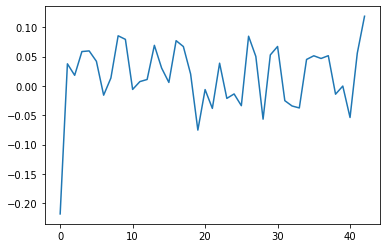

In [70]:
plt.plot(predicted_returns)

In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from ta.trend import EMAIndicator, MACD, ADXIndicator, AroonIndicator, CCIIndicator, PSARIndicator
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

# --- 1. Download Data ---
data = yf.download("^NSEI", start="2008-01-01", end="2023-12-31")
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- Remove February data ---
data = data[~((data.index.month == 2))]  # Remove February data
prices = data["Close"].values
dates = data.index
high_prices = data["High"].values
low_prices = data["Low"].values

# --- 2. Feature Engineering (All TA-Lib Features) ---
def calculate_all_ta_features(price_index):
    # Calculate EMA
    ema_period = 12
    ema_indicator = EMAIndicator(close=pd.Series(prices[:price_index + 1]), window=ema_period)
    ema = ema_indicator.ema_indicator().iloc[-1] if len(ema_indicator.ema_indicator()) > 0 else 0

    # Calculate MACD
    macd_indicator = MACD(close=pd.Series(prices[:price_index + 1]))
    macd = macd_indicator.macd().iloc[-1] if len(macd_indicator.macd()) > 0 else 0
    macd_signal = macd_indicator.macd_signal().iloc[-1] if len(macd_indicator.macd_signal()) > 0 else 0
    macd_diff = macd_indicator.macd_diff().iloc[-1] if len(macd_indicator.macd_diff()) > 0 else 0
    # Calculate Aroon
    aroon_indicator = AroonIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                    low=pd.Series(low_prices[:price_index + 1]), window=25)
    aroon_up = aroon_indicator.aroon_up().iloc[-1] if len(aroon_indicator.aroon_up()) > 0 else 0
    aroon_down = aroon_indicator.aroon_down().iloc[-1] if len(aroon_indicator.aroon_down()) > 0 else 0

    # Calculate CCI
    cci_indicator = CCIIndicator(high=pd.Series(high_prices[:price_index + 1]),
                                low=pd.Series(low_prices[:price_index + 1]),
                                close=pd.Series(prices[:price_index + 1]), window=20)
    cci = cci_indicator.cci().iloc[-1] if len(cci_indicator.cci()) > 0 else 0

    # Calculate PSAR
    psar = PSARIndicator(high=pd.Series(high_prices[:price_index + 1]), low=pd.Series(low_prices[:price_index + 1]),
                         close=pd.Series(prices[:price_index + 1]))
    psar_value = psar.psar().iloc[-1] if len(psar.psar()) > 0 else 0

    return [ema, macd, macd_signal, macd_diff,  aroon_up, aroon_down, cci, psar_value]


ta_features_list = []
for i in range(len(prices)):
    ta_features = calculate_all_ta_features(i)
    ta_features_list.append(ta_features)

ta_features = np.array([f for f in ta_features_list if f is not None])

# --- 7. Feature Selection (Removed) ---
# Feature selection is removed; all features will be used.

# --- 12. Factor Model ---
if len(ta_features) > 1:
    # Resample the entire DataFrame
    monthly_data = data.resample('M').last()
    # Remove February data from monthly_data
    monthly_data = monthly_data[~((monthly_data.index.month == 2))]
    # Calculate monthly returns from the resampled DataFrame
    monthly_returns = monthly_data['Close'].pct_change().dropna().values

    # Align features with monthly returns (select features corresponding to the last day of each month)
    aligned_features = []
    for date in monthly_data.index:
        try:
            feature_index = data.index.get_loc(date)
        except KeyError:
            feature_index = data.index.asof(date)
            if feature_index not in data.index:
                print(f"Warning: Date {date} not found in original data and asof failed. Skipping this month.")
                continue
            feature_index = data.index.get_loc(feature_index)
        aligned_features.append(ta_features[feature_index])
    aligned_features = np.array(aligned_features)

    # Ensure the same number of samples
    min_samples = min(len(aligned_features), len(monthly_returns))
    aligned_features = aligned_features[:min_samples]
    monthly_returns = monthly_returns[:min_samples]

    # Check for NaN/inf in features and returns
    print("NaN in aligned_features:", np.isnan(aligned_features).any())
    print("inf in aligned_features:", np.isinf(aligned_features).any())
    print("NaN in monthly_returns:", np.isnan(monthly_returns).any())
    print("inf in monthly_returns:", np.isinf(monthly_returns).any())

    # Replace NaN and inf with 0
    aligned_features = np.nan_to_num(aligned_features, nan=0, posinf=0, neginf=0)
    monthly_returns = np.nan_to_num(monthly_returns, nan=0, posinf=0, neginf=0)

    # Create a linear regression model
    factor_model = LinearRegression()

    # Fit the model.  Use monthly returns as the target variable.
    try:
        factor_model.fit(aligned_features, monthly_returns)
        # Print the coefficients (factor loadings)
        print("\nFactor Model Coefficients (Factor Loadings):")
        print(factor_model.coef_)
        print("\nFactor Model Intercept:")
        print(factor_model.intercept_)

        # --- 13. Trading Strategy and Backtesting ---
        # Get the closing prices for backtesting
        backtest_prices = monthly_data['Close'].values
        backtest_dates = monthly_data.index

        # Initialize strategy variables
        position = 0  # 0: no position, 1: long, -1: short
        cumulative_returns = [1]  # Start with an initial investment of 1
        trade_prices = []
        trade_signals = []

        # Backtesting loop
        for i in range(1, len(backtest_prices)):  # Start from the second month
            # Get the current price
            current_price = backtest_prices[i]
            # Get the features for the current month
            current_features = aligned_features[i-1].reshape(1, -1)  # Reshape for prediction

            # Predict the return from the factor model
            predicted_return = factor_model.predict(current_features)[0]

            # Generate trade signals
            if predicted_return > 0:  # Buy signal (expecting positive return)
                signal = -1
            elif predicted_return < 0:  # Sell signal (expecting negative return)
                signal = 1
            else:
                signal = 0  # No action

            # Execute trades
            if signal != position:
                if position != 0:  # Close existing position
                    trade_prices.append(current_price)
                    trade_signals.append(position)
                    return_of_trade = (current_price / backtest_prices[i-1]) if position == 1 else (backtest_prices[i-1] / current_price)
                    cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

                position = signal  # Open new position

        # Close any open position at the end
        if position != 0:
            trade_prices.append(backtest_prices[-1])
            trade_signals.append(position)
            return_of_trade = (backtest_prices[-1] / backtest_prices[-2]) if position == 1 else (backtest_prices[-2] / backtest_prices[-1])
            cumulative_returns.append(cumulative_returns[-1] * return_of_trade)

        cumulative_returns = np.array(cumulative_returns)

        # --- 14. Evaluate Performance ---
        total_return = cumulative_returns[-1] - 1 if len(cumulative_returns) > 0 else 0
        annualized_return = (1 + total_return) ** (12 / len(cumulative_returns)) - 1 if len(cumulative_returns) > 1 else 0  # annualize by month
        annualized_volatility = np.std(np.diff(np.log(cumulative_returns))) * np.sqrt(
            12) if len(cumulative_returns) > 1 else 0
        sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0
        max_drawdown = (pd.Series(cumulative_returns).cummax() - pd.Series(cumulative_returns)).max() if len(
            cumulative_returns) > 0 else 0

        print("\nTrading Strategy Performance Metrics:")
        print(f"Total Return: {total_return*100:.4f}")
        print(f"Annualized Return: {annualized_return:*100:.4f}")
        print(f"Annualized Volatility: {annualized_volatility:.4f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Maximum Drawdown: {max_drawdown:.4f}")

        # --- 15. Visualize Results ---
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_returns, label="Factor Model Strategy")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Returns")
        plt.title("Factor Model-Based Trading Strategy")
        plt.legend()
        plt.grid(True)
        plt.show()

    except ValueError as e:
        print(f"\nError fitting factor model: {e}")
        print("Check the shapes and data types of the features and monthly_returns.")

else:
    print("No valid features found. Check your persistence diagram calculations or data.")

[*********************100%%**********************]  1 of 1 completed


NaN in aligned_features: True
inf in aligned_features: False
NaN in monthly_returns: False
inf in monthly_returns: False

Factor Model Coefficients (Factor Loadings):
[ 1.73808374e-05  2.12612653e-05 -6.35722661e-05  8.48335315e-05
  2.64203867e-04  1.44989808e-04 -8.29754273e-05 -1.69955782e-05]

Factor Model Intercept:
-0.01294232009977919

Trading Strategy Performance Metrics:
Total Return: 24.2113

Error fitting factor model: Invalid format specifier
Check the shapes and data types of the features and monthly_returns.


In [86]:
 print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.4204


In [85]:
print(f"Annualized Return: {annualized_return*100:.4f}")

Annualized Return: 6.0914
